Titanic dataset: predicting survived passengers

In [396]:
from keras.layers import Input, Dense, Activation, LSTM, merge, Conv1D, MaxPooling1D, Flatten, Dropout, Embedding, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam

In [37]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np

In [5]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [6]:
labels = train_df.Survived.values
train_df.drop('Survived', axis=1, inplace=True)

In [7]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [8]:
train_df["Sex"] = train_df["Sex"].apply(lambda x: 1 if x == "male" else 0)
test_df["Sex"] = train_df["Sex"].apply(lambda x: 1 if x == "male" else 0)

In [9]:
train_df["Cabin"] = train_df["Cabin"].apply(lambda x: 1 if x != 0 else 0)
test_df["Cabin"] = train_df["Cabin"].apply(lambda x: 1 if x != 0 else 0)

In [10]:
train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S


In [433]:
numeric_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin"]

In [434]:
X_numeric = train_df[numeric_features].values

In [435]:
X_numeric.shape

(891, 7)

In [436]:
text_features = ["Name", "Ticket", "Embarked"]

In [437]:
def load_data(symbols):
    vocab = {}
    words = list(symbols.lower())
    for i, word in enumerate(words):
        if word not in vocab:
            vocab[word] = len(vocab)
    print('corpus length:', len(words))
    print('vocab size:', len(vocab))
    return vocab

In [438]:
all_symbols = ""
for x in train_df[text_features].values:
    all_symbols += " ".join(map(str, x)) + " "

In [439]:
vocab = load_data(all_symbols)

corpus length: 33605
vocab size: 45


In [440]:
max_name_length = train_df.Name.apply(len).max()
max_ticket_length = train_df.Ticket.apply(len).max()
train_df["Embarked"] = train_df.Embarked.apply(lambda x: "s" if x == 0 else x.lower())
max_embarked_length = train_df.Embarked.apply(len).max()

In [441]:
X_text = np.zeros((891, max_name_length + max_ticket_length + max_embarked_length))

In [442]:
for e, i in enumerate(train_df[text_features].iterrows()):
    name = i[1]["Name"].lower()
    ticket = i[1]["Ticket"].lower()
    emb = i[1]["Embarked"].lower()
    for p, w in enumerate(name):
        X_text[e, p] = vocab[w]
    for p, w in enumerate(ticket):
        X_text[e, p + max_name_length] = vocab[w]
    for p, w in enumerate(emb):
        X_text[e, p + max_name_length + max_ticket_length] = vocab[w] 

In [443]:
X_text.shape

(891, 101)

In [444]:
X_numeric.shape

(891, 7)

In [445]:
split_n = int(0.25 * len(train_df))

In [446]:
split_n

222

In [447]:
X_text_train, X_text_test = X_text[split_n:], X_text[:split_n]
X_numeric_train, X_numeric_test = X_numeric[split_n:], X_numeric[:split_n]

In [448]:
y_train, y_test = labels[split_n:], labels[:split_n]

In [449]:
y_train.mean(), y_test.mean()

(0.39461883408071746, 0.35135135135135137)

In [450]:
len(vocab)

45

In [451]:
numeric_input = Input(shape=(7,), name='numeric_input')
y = Dense(3)(numeric_input)

text_input = Input(shape=(101,), name='text_input')
x = Embedding(len(vocab), 64, input_length=101) (text_input)
x = Conv1D(16, 4, activation='relu', subsample_length=1)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(16)(x)
x = Dropout(0.5)(x)

conv_output = Dense(1, activation='sigmoid', name='conv_output')(x)

x = merge([x, y], mode='concat')

preds = Dense(1, activation='sigmoid', name='main_output')(x)

In [452]:
adam = Adam(lr=0.0001)

In [453]:
model = Model(input=[numeric_input, text_input], output=[preds, conv_output])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"], loss_weights=[1, 0.2])

In [454]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
text_input (InputLayer)          (None, 101)           0                                            
____________________________________________________________________________________________________
embedding_15 (Embedding)         (None, 101, 64)       2880        text_input[0][0]                 
____________________________________________________________________________________________________
convolution1d_57 (Convolution1D) (None, 98, 16)        4112        embedding_15[0][0]               
____________________________________________________________________________________________________
globalmaxpooling1d_6 (GlobalMaxPo(None, 16)            0           convolution1d_57[0][0]           
___________________________________________________________________________________________

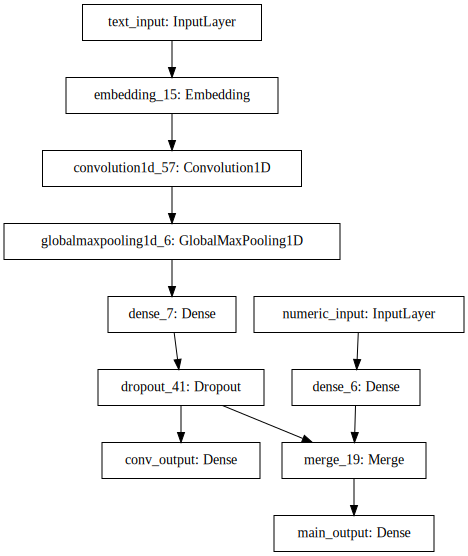

In [455]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [456]:
N_EPOCHS = 100

In [457]:
%%time
train_scores = []
test_scores = []
for epoch in range(N_EPOCHS):
    model.fit([X_numeric_train, X_text_train], [y_train, y_train], nb_epoch=1, batch_size=8, verbose=0)
    probas = model.predict([X_numeric_train, X_text_train])[0]
    a, r, l = accuracy_score(y_train, probas > 0.5), roc_auc_score(y_train, probas), log_loss(y_train, probas)
    train_scores.append((a, r, l))
    probas = model.predict([X_numeric_test, X_text_test])[0]
    a, r, l = accuracy_score(y_test, probas > 0.5), roc_auc_score(y_test, probas), log_loss(y_test, probas)
    test_scores.append((a, r, l))

CPU times: user 21.2 s, sys: 304 ms, total: 21.5 s
Wall time: 22.8 s


In [458]:
probas = model.predict([X_numeric_test, X_text_test])[0]

In [459]:
probas.mean()

0.35572314

In [460]:
train_scores = pd.DataFrame([x for x in train_scores], columns=["accuracy", "roc_auc", "log_loss"])
test_scores = pd.DataFrame([x for x in test_scores], columns=["accuracy", "roc_auc", "log_loss"])
train_scores["phase"] = "train"
test_scores["phase"] = "test"
scores = pd.concat([train_scores, test_scores])
scores["epoch"] = scores.index

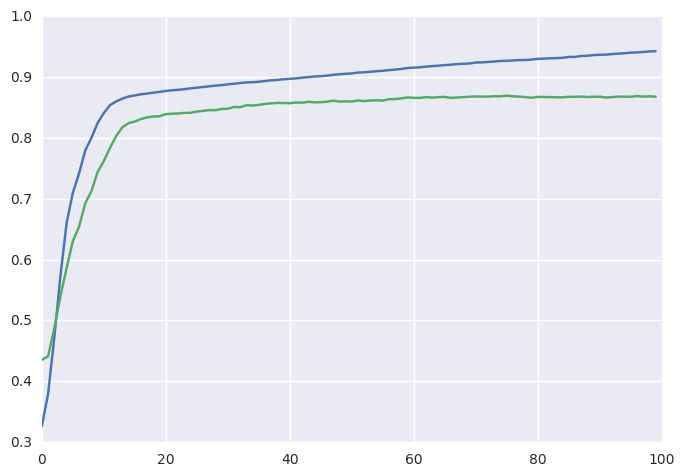

In [461]:
plt.plot(scores[scores.phase=="train"].epoch, scores[scores.phase=="train"].roc_auc)
plt.plot(scores[scores.phase=="test"].epoch, scores[scores.phase=="test"].roc_auc)
plt.show()

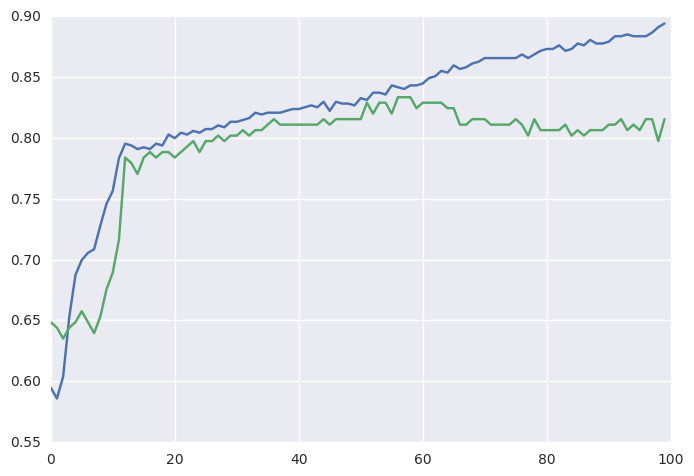

In [462]:
plt.plot(scores[scores.phase=="train"].epoch, scores[scores.phase=="train"].accuracy)
plt.plot(scores[scores.phase=="test"].epoch, scores[scores.phase=="test"].accuracy)
plt.show()

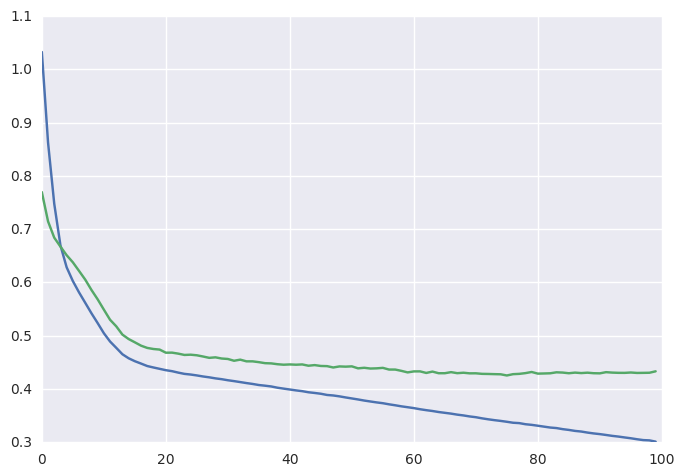

In [464]:
plt.plot(scores[scores.phase=="train"].epoch, scores[scores.phase=="train"].log_loss)
plt.plot(scores[scores.phase=="test"].epoch, scores[scores.phase=="test"].log_loss)
plt.show()

In [469]:
X_numeric_submit = test_df[numeric_features].values

In [470]:
X_numeric_submit.shape

(418, 7)

In [471]:
X_text_submit = np.zeros((418, max_name_length + max_ticket_length + max_embarked_length))

In [472]:
for e, i in enumerate(test_df[text_features].iterrows()):
    name = i[1]["Name"].lower()
    ticket = i[1]["Ticket"].lower()
    emb = i[1]["Embarked"].lower()
    for p, w in enumerate(name):
        X_text_submit[e, p] = vocab[w]
    for p, w in enumerate(ticket):
        X_text_submit[e, p + max_name_length] = vocab[w]
    for p, w in enumerate(emb):
        X_text_submit[e, p + max_name_length + max_ticket_length] = vocab[w] 

In [473]:
X_text_submit.shape

(418, 101)

In [474]:
X_numeric_submit.shape

(418, 7)

In [475]:
submit_probas = model.predict([X_numeric_submit, X_text_submit])[0]

In [481]:
np.mean(submit_probas > 0.5)

0.35645933014354064

In [482]:
np.mean(y_train)

0.39461883408071746

In [483]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,0,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,1,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,0,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,1,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,S


In [486]:
with open("/data/pavel/submit.out", "w") as f:
    print("PassengerId,Survived", file=f)
    for i, s in zip(test_df.PassengerId.values, submit_probas):
        print(i, 1 if s > 0.5 else 0, file=f, sep=",")